In [1]:
import numpy as np
import torch
import torch_geometric
import open3d as o3d
#utils
import h5py
import os
import dataclasses

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss
from sklearn.model_selection import train_test_split
from datetime import datetime






Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


## Utils

In [2]:
from utils import model_size

### Load data

In [3]:
from utils.data import load_h5_data, PairData, PCDDataset
from torch_geometric.loader import DataLoader as PyGLoader

### Viz

In [4]:
from utils.viz import viz_many_mpl

### Configs

In [5]:
from train.config import TrainConfig, ModelConfig, DataConfig


In [6]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")
model_config = ModelConfig()
train_config = TrainConfig()
data_config = DataConfig(path = data_path)


In [7]:
print(model_config)
print(train_config)
print(data_config)

ModelConfig(num_point=256, up_ratio=4, dilation=2, num_neighbours=20, n_idgcn_blocks=2, channels=24, n_dgcn_blocks=3)
TrainConfig(batch_size=8, epochs=10)
DataConfig(path='../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', skip_rate=5, use_randominput=True, num_point=256)


# Data

In [8]:
#Load dataset
dataset = PCDDataset.from_h5(data_path, num_point=data_config.num_point, up_ratio=model_config.up_ratio, skip_rate=data_config.skip_rate)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 13800 samples


In [9]:
# Check one samples
data = dataset[42]
data_cloud, gt_cloud = data.pos_s, data.pos_t

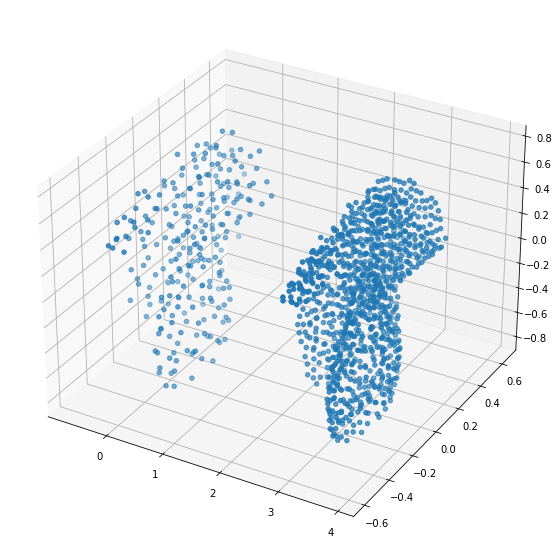

In [10]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([data_cloud, gt_cloud], ax = ax)

# Training

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
from pugcn_lib import PUGCN

In [13]:
train_perc = .8
trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)], generator=torch.Generator().manual_seed(42))

In [14]:
trainset.dataset.augment = True
valset.dataset.augment = False

In [15]:
# trainloader = DataLoader(trainset, batch_size=64)
# valloader = DataLoader(valset, batch_size=64, shuffle=False)
trainloader = PyGLoader(trainset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
valloader = PyGLoader(valset, batch_size=train_config.batch_size, shuffle=False, follow_batch = ['pos_s', 'pos_t'])


In [16]:
pugcn = PUGCN(
    channels = model_config.channels,
    k = model_config.num_neighbours,
    r = model_config.up_ratio,
    n_idgcn_blocks=model_config.n_idgcn_blocks,
    n_dgcn_blocks=model_config.n_dgcn_blocks,
    use_bottleneck = True,
    use_pooling = True,
    use_residual = True
).to(device)

loss_fn = loss_fn = ChamferLoss()
optimizer = torch.optim.Adam(params = pugcn.parameters(), lr = train_config.lr)

In [17]:
model_size(pugcn)

0.035

In [18]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

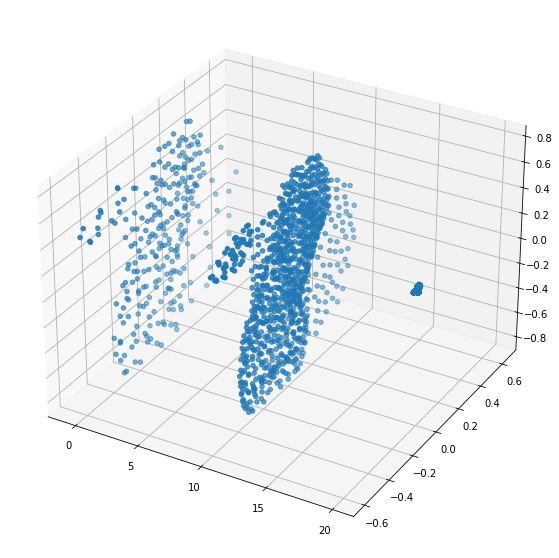

In [19]:
pred = pugcn(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

viz_many_mpl([data_cloud, gt_cloud, pred], d = 10, ax = ax)

In [20]:
def train(model, trainloader, loss_fn, optimizer):

    total_loss = 0.0
    for d in (t := tqdm(trainloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        # get batch and target dimesnions since chamfer loss will need rehsaping
        b, nq = p_batch.max().item() + 1, q.shape[0]

        # Train step
        optimizer.zero_grad()

        pred = model(p, batch=p_batch)
        d1, d2, _, _ = loss_fn(pred.reshape(b, nq // b, 3), q.reshape(b, nq // b, 3))
        loss = d1.mean() + d2.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss


@torch.no_grad()
def evaluate(model, valloader, loss_fn):

    total_loss = 0.0
    for d in (t := tqdm(valloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        # get batch and target dimesnions since chamfer loss will need rehsaping
        b, nq = p_batch.max().item() + 1, q.shape[0]

        pred = model(p, batch=p_batch)
        d1, d2, _, _ = loss_fn(pred.reshape(b, nq // b, 3), q.reshape(b, nq // b, 3))
        loss = d1.mean() + d2.mean()

        total_loss += loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss
    

In [21]:
if "trained-models" not in os.listdir("."):
    os.mkdir("trained-models")
dir_name = datetime.now().strftime("%d_%m_%Y_%H_%M")
os.mkdir(os.path.join("trained-models", dir_name))
print(f"Saving checkpoints at {dir_name}")

In [22]:
history = {}
history["train_loss"] = []
history["val_loss"] = []
for epoch in tqdm(range(train_config.epochs)):
    train_loss = train(pugcn, trainloader, loss_fn, optimizer)
    val_loss = evaluate(pugcn, valloader, loss_fn)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    print(f"{epoch=} \t {train_loss=:.6f} \t {val_loss=:.6f}")
    
    torch.save(
        {
            "model_config": model_config.__dict__,
            "train_config": train_config.__dict__,
            "data_config": data_config.__dict__,
            "history": history
            "epoch": epoch,
            "model_size": model_size(pugcn, unit = "KB")
            "model_state_dict": pugcn.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        os.path.join("trained-models", dir_name, f"ckpt_epoch-{epoch}"),
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=0 	 train_loss=56.122963 	 val_loss=5.671440
Saving checkpoints at 02_03_2022_17_20


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=1 	 train_loss=20.607142 	 val_loss=4.911781
Saving checkpoints at 02_03_2022_17_24


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=2 	 train_loss=18.045374 	 val_loss=4.262763
Saving checkpoints at 02_03_2022_17_27


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=3 	 train_loss=16.107484 	 val_loss=3.860654
Saving checkpoints at 02_03_2022_17_31


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=4 	 train_loss=14.503040 	 val_loss=3.266518
Saving checkpoints at 02_03_2022_17_34


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=5 	 train_loss=11.008099 	 val_loss=2.237118
Saving checkpoints at 02_03_2022_17_37


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=6 	 train_loss=7.166304 	 val_loss=1.235581
Saving checkpoints at 02_03_2022_17_41


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=7 	 train_loss=4.101009 	 val_loss=0.965564
Saving checkpoints at 02_03_2022_17_44


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=8 	 train_loss=3.593840 	 val_loss=0.902802
Saving checkpoints at 02_03_2022_17_48


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

epoch=9 	 train_loss=3.470247 	 val_loss=0.878793
Saving checkpoints at 02_03_2022_17_51


In [ ]:
# Train 1 epoch 
train_loss = train(pugcn, trainloader, loss_fn, optimizer)


In [23]:
idx = np.random.choice(len(valset))
dv = valset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [24]:
pred = pugcn(sample.to(device)).cpu().detach().numpy()
pred

array([[ 0.21489479, -0.49271792,  0.3335713 ],
       [ 0.18561362, -0.45916536,  0.34066212],
       [ 0.22431235, -0.44709674,  0.29485655],
       ...,
       [-0.44180876,  0.0770881 ,  0.13629958],
       [-0.3722483 ,  0.06869565,  0.11687894],
       [-0.40085   ,  0.07853834,  0.09385857]], dtype=float32)

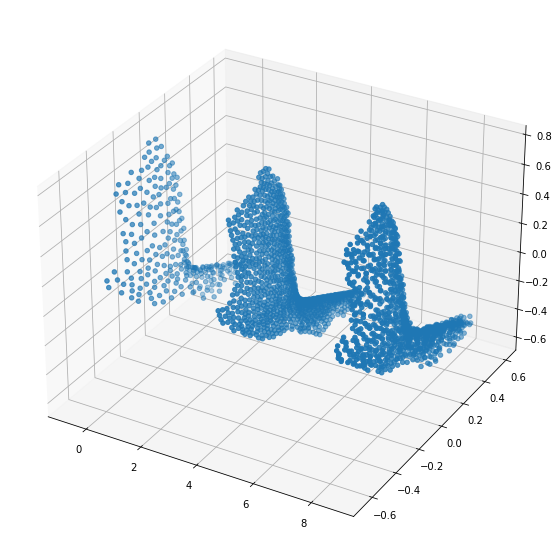

In [25]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([sample, gt, pred], d = 4, ax = ax)

In [34]:
checkpoint = torch.load(os.path.join("trained-models", "ckpt1"))

In [1]:
#checkpoint